In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import csv
from datetime import datetime as dt
import seaborn as sns
from networkx.algorithms import bipartite
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [ ]:
interactions_train = pd.read_csv('interactions_train.csv', engine='python', on_bad_lines='skip')
interactions_test = pd.read_csv('interactions_test.csv', engine='python', on_bad_lines='skip')
interactions_validation = pd.read_csv('interactions_validation.csv', engine='python', on_bad_lines='skip')
interactions = pd.concat([interactions_train, interactions_test, interactions_validation], axis=0, join='outer')
users = pd.read_csv('PP_users.csv', engine='python', on_bad_lines='skip')
recipes = pd.read_csv('RAW_recipes.csv', engine='python', on_bad_lines='skip')

# Exploratory Data Analysis

## Interactions EDA
user_id - User ID \\
recipe_id - Recipe ID \\
date - Date of interaction between user and recipe \\
rating - User's rating given for the recipe \\
review - User's review text for the recipe \\
u - User ID, mapped to contiguous integers from 0 \\
i - Recipe ID, mapped to contiguous integers from 0 \\

Note: Despite what the Kaggle metadata claims, the mapped/processed recipe IDs aren't contiguous. This is likely due to the fact that not all the recipes in the recipes data show up in the interactions data. This is not vital to our analysis.

In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718379 entries, 0 to 7022
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    718379 non-null  int64         
 1   recipe_id  718379 non-null  int64         
 2   date       718379 non-null  datetime64[ns]
 3   rating     718379 non-null  float64       
 4   u          718379 non-null  int64         
 5   i          718379 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 38.4 MB


In [ ]:
interactions.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [ ]:
# convert to DateTime object
interactions['date'] = pd.to_datetime(interactions['date'])

Text(0.5, 1.0, 'Distribution of date')

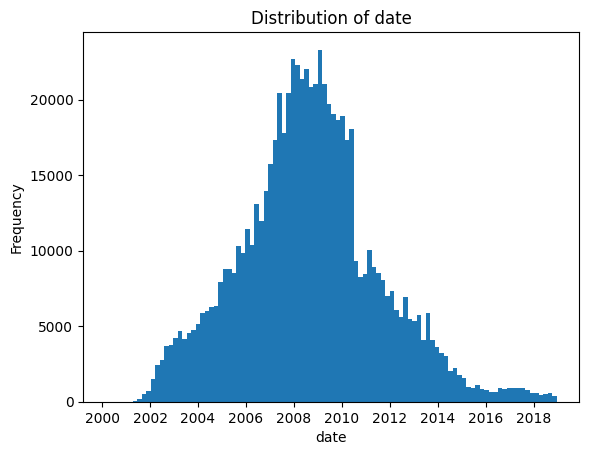

In [ ]:
plt.hist(interactions['date'], bins=100)
plt.xlabel('date')
plt.ylabel('Frequency')
plt.title('Distribution of date')

Text(0.5, 1.0, 'Distribution of rating')

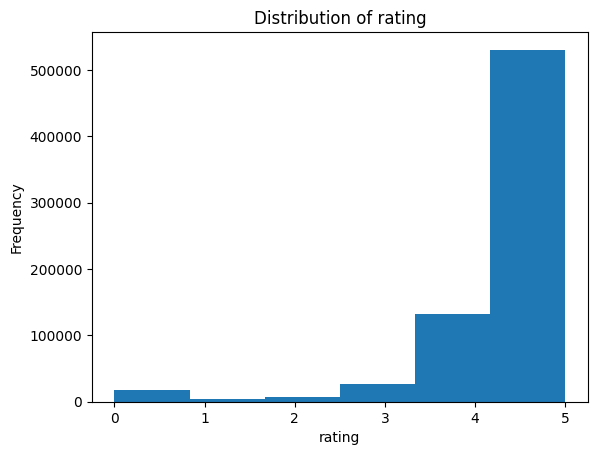

In [ ]:
plt.hist(interactions['rating'], bins=6)
plt.xlabel('rating')
plt.ylabel('Frequency')
plt.title('Distribution of rating')

## Recipes EDA
name - Recipe name \\
id - Recipe ID \\
minutes - Minutes to prepare recipe \\
contributor_id - User ID who submitted this recipe \\
submitted - Date the recipe was submitted \\
tags - Food.com tags for recipe \\
nutrition - Nutrition info: [calories, total fat (PDV), sugar (PDV), sodium (PDV), protein (PDV), saturated fat]* \\
n_steps - Number of steps in recipe \\
steps - Text for recipe steps in order \\
description - Contributor-provided description \\

*(PDV = percent daily value)

In [ ]:
recipes.head(1)

,index,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,ingredients,n_ingredients
0,0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[winter squash, mexican seasoning, mixed spice...",7


In [ ]:
# since we're most likely not doing anything with the 'steps' or 'description' columns, we'll simply remove them
recipes = recipes.drop(['steps', 'description'], axis=1)

# there's one row whose 'name' entry is 'NaN' which could cause issues, so we can remove that
recipes = recipes.dropna().reset_index()

In [ ]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231636 entries, 0 to 231635
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           231636 non-null  int64         
 1   name            231636 non-null  object        
 2   id              231636 non-null  int64         
 3   minutes         231636 non-null  int64         
 4   contributor_id  231636 non-null  int64         
 5   submitted       231636 non-null  datetime64[ns]
 6   tags            231636 non-null  object        
 7   nutrition       231636 non-null  object        
 8   n_steps         231636 non-null  int64         
 9   ingredients     231636 non-null  object        
 10  n_ingredients   231636 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 19.4+ MB


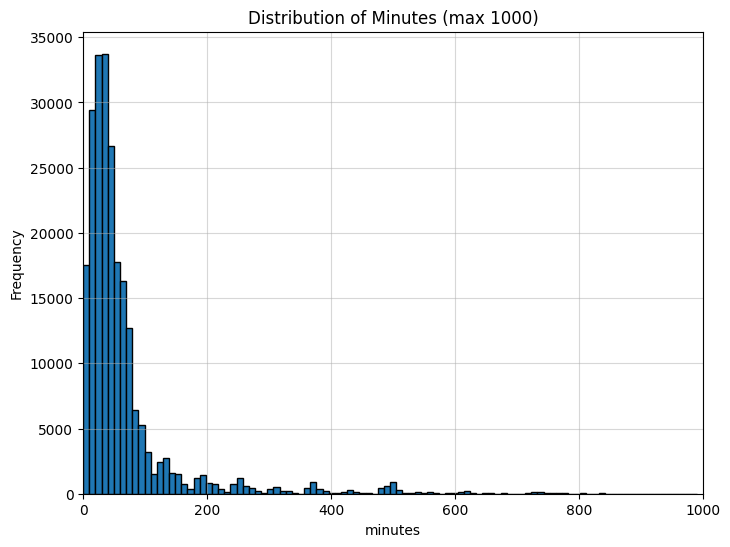

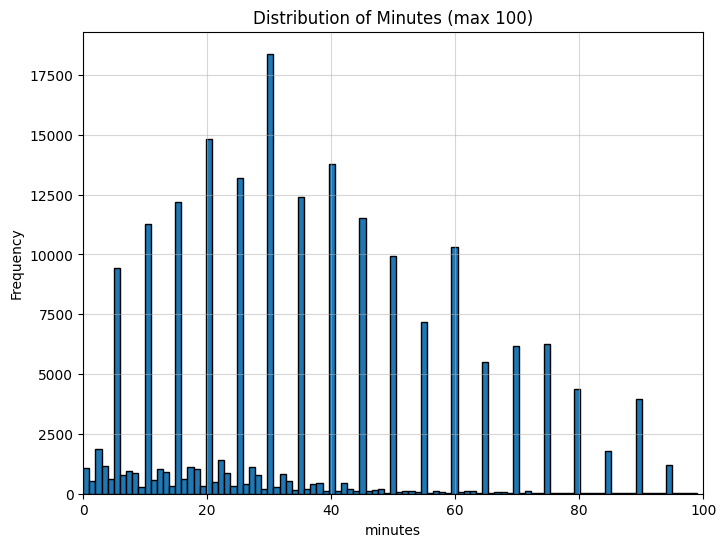

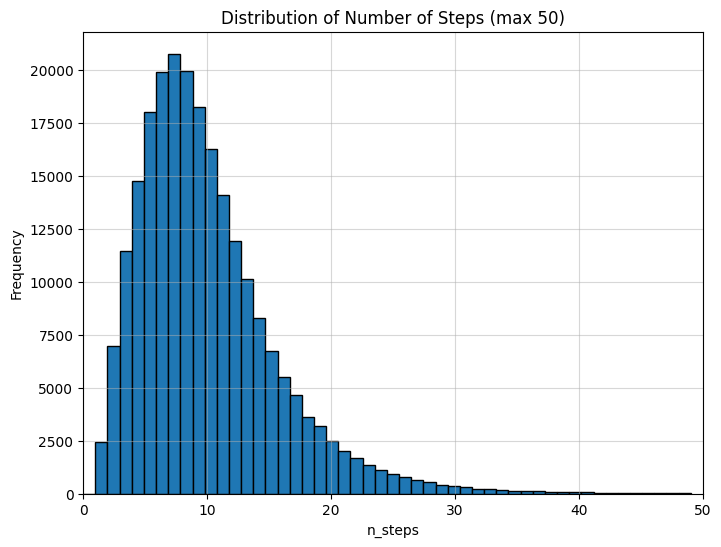

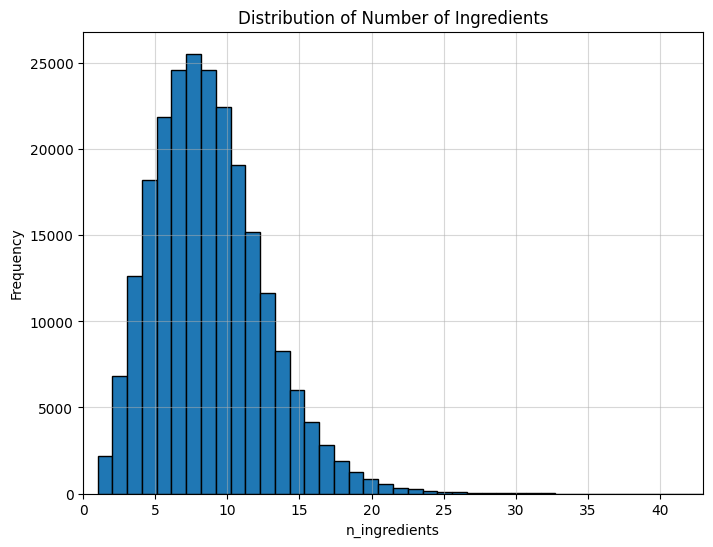

In [ ]:
# convert 'submitted' variable from string to date object
recipes['submitted'] = pd.to_datetime(recipes['submitted'])

# Select numerical columns for visualization, and define ranges and bins for each
cols = [recipes[recipes['minutes'] < 1000]['minutes'],
        recipes[recipes['minutes'] < 100]['minutes'],
        recipes[recipes['n_steps'] < 50]['n_steps'],
        recipes['n_ingredients']]
col_names = ['minutes', 'minutes', 'n_steps', 'n_ingredients']
bins = [100, 100, 50, len(recipes['n_ingredients'].unique())]
titles = ['Distribution of Minutes (max 1000)',
          'Distribution of Minutes (max 100)',
          'Distribution of Number of Steps (max 50)',
          'Distribution of Number of Ingredients']
xlims = [1000, 100, 50, np.max(recipes['n_ingredients'])]

# Define a function that takes in details of a histogram plot and plots it

def plot_histograms(col, col_name, bins, title, xlim):
    plt.figure(figsize=(8, 6))
    plt.hist(col, bins=bins, edgecolor='black')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.xlim(0, xlim)
    plt.title(title)
    plt.grid(True, alpha=0.5)
    plt.show()

# Create histograms for each numerical column

for col, col_name, bins, title, xlim in zip(cols, col_names, bins, titles, xlims):
    plot_histograms(col, col_name, bins, title, xlim)

In [ ]:
# Make 'tags' variable a list
n_recipes = len(recipes)
tags = recipes['tags'].copy()

for i in range(0, n_recipes):
  tags[i] = eval(recipes['tags'][i])

recipes['tags'] = tags

In [ ]:
tags_raw = {}

for taglist in recipes.tags:
    for tag in taglist:
        if tag not in tags_raw:
            tags_raw[tag] = 1
        else:
            tags_raw[tag] += 1

print('There are ', len(tags_raw), 'tags in total.')

There are  552 tags in total.


In [ ]:
# we can see some categories of tags
# I omitted some tags that were too vague like 'preparation' or 'course'

# CUISINE
  # north-american, mexican, american, northeastern-united-states, amish-mennonite, canadian, south-west-pacific, hawaiian, southwestern-united-states, asian, indian
  # californian, german, european, italian, midwestern, southern-united-states, indonesian, pacific-northwest, polish, chinese, british-columbian, danish, scandinavian
  # swiss, swedish, french, african, creole, cajun, australian, caribbean, central-american, english, quebec, middle-eastern, lebanese, greek, south-american
  # russian, baja, japanese, native-american, spanish, irish, polynesian, thai, ontario, tex-mex, south-african, new-zealand, pennsylvania-dutch, welsh, filipino, cuban
  # korean, belgian, finnish, moroccan, iranian, persian, dutch, turkish, portuguese, hungarian, brazilian, egyptian, vietnamese, norwegian, austrian, soul
# FOOD CATEGORIES
  # meats/animal products
    # meat, pork, pork-ribs, pork-chops, beef, poultry, chicken, ground-beef, wild-game, deer, chicken-breasts, beef-ribs, bacon, turkey, whole-turkey, beef-sausage
    # steak, steaks, roast-beef, pork-sausage, wings, pork-loins, ham, lamb-sheep, whole-chicken, turkey-breasts, duck, chicken-thighs-and-legs, veal
    # gelatin, eggs, eggs-dairy, cheese
  # seafood
    # seafood, fish, tuna, saltwater-fish, salmon, no-shell-fish, shrimp, shellfish, crab, freshwater-fish, catfish, clams, halibut, scallops, tilapia, cod
    # sole-and-flounder, mussels, oysters, lobster
  # vegetables and fruits bc idk which belong to which: vegetables, fruit, greens, salads, tropical-fruit, squash, chili, potatoes, apples, bananas, berries, strawberries, beans
    # cauliflower, spinach, peppers, black-beans, nuts, pineapple, corn, grapes, soy-tofu, tomatoes, onions, broccoli, lettuces, lentils, asparagus, simply-potatoes
    # mango, green-yellow-beans, coconut, citrus, oranges, papaya, pitted-fruit, peaches, blueberries, zucchini, lemon, chick-peas-garbanzos, carrots, yams-sweet-potatoes
    # lime, melons, raspberries, pears, cherries, plums
  # drinks
    # beverages, shakes, smoothies, cocktails, punch
  # desserts
    # desserts, frozen-desserts, baking, cooking-mixes, pies-and-tarts, pies, chocolate, candy, cookies-and-brownies, bar-cookies, brownies, muffins
    # cakes, cheesecake, pancakes-and-waffles, rolled-cookies, drop-cookies, savory-pies, fudge, biscotti, puddings-and-mousses, cobblers-and-crisps
    # cupcakes, hand-formed-cookies, scones, crusts-pastry-dough, coffee-cakes, tarts, cake-fillings-and-frostings
  # soups, stews
    # stews, stocks, bisques-cream-soups, soups-stews, clear-soups, gumbo, chowders
  # grains, pastas, breads
    # pasta, pasta-rice-and-grains, breads, quick-breads, grains, rice, brown-rice, white-rice, long-grain-rice, short-grain-rice, elbow-macaroni, spaghetti, ravioli-tortellini
    # rolls-biscuits, pasta-shells, penne
  # general foods
    # pizza, sandwiches, lasagna, omelets-and-frittatas, finger-food, casseroles, granola-and-porridge, burgers, manicotti
  # fungi
    # mushrooms, yeast
  # sauces and spreads and such
    # sauces, sweet-sauces, savory-sauces, spreads, dips, salad-dressings, curries, peanut-butter, salsas, chutneys, jams-and-preserves
    # jellies, stuffings-dressings, marinades-and-rubs
  # herby, garnishy things
    # herb-and-spice-mixes, garnishes
# TIME TO MAKE
  # 15-minutes-or-less, 30-minutes-or-less, 60-minutes-or-less, 4-hours-or-less, 1-day-or-more
# TYPE OF DISH
  # side-dishes, main-dish, appetizers, one-dish-meal
# TIME OF YEAR
  # spring, summer, fall, winter, seasonal
# HOLIDAYS
  # holiday-event, christmas, easter, new-years, thanksgiving, independence-day, st-patricks-day, valentines-day, superbowl, super-bowl, halloween, birthday
# TIME OF DAY
  # breakfast, brunch, lunch, dinner-party, snacks
# EVENTS
  # for-large-groups, for-1-or-2, potluck, picnic, barbecue, wedding, camping
# DIET SPECIFICS
  # vegan, vegetarian, low-protein, low-sodium, low-calorie, low-fat, low-in-something, healthy, lactose, free-of-something, low-cholesterol, low-carb, healthy-2, low-saturated fat
  # high-calcium, high-protein, high-in-something, very-low-carbs, gluten-free, diabetic, egg-free, dairy-free, high-fiber, non-alcoholic, nut-free,
# APPLIANCES/TECHNIQUES
  # oven, crock-pot-slow-cooker, stove-top, freezer, no-cook, refrigerator, oamc-freezer-make-ahead, deep-fry, food-processor-blender, small-appliance, grilling, mixer
  # roast, broil, barbecue, steam, microwave, bread-machine, stir-fry, pressure-cooker, water-bath,
# RELIGIONS
  # jewish-sephardi, jewish-ashkenazi, kosher, ramadan, kwanzaa, hanukkah, rosh-hashana, mardi-gras-carnival, passover
# other
  # kid-friendly, toddler-friendly, infant-baby-friendly, inexpensive, served-hot, served-cold, novelty, spicy, savory, sweet, comfort-food, to-go, gifts, romantic
  # leftovers, brown-bag, celebrity, easy, beginner-cook, 5-ingredients-or-less, 3-steps-or-less

In [ ]:
# Make 'ingredients' variable a list

n_recipes = len(recipes)
ingredients = recipes['ingredients'].copy()

for i in range(0, n_recipes):
  ingredients[i] = eval(recipes['ingredients'][i])

recipes['ingredients'] = ingredients

In [ ]:
ingredients_raw = {}

for ing_list in recipes.ingredients:
    for ingredient in ing_list:
        if ingredient not in ingredients_raw:
            ingredients_raw[ingredient] = 1
        else:
            ingredients_raw[ingredient] += 1

print('There are ', len(ingredients_raw), 'ingredients in total.')

There are  14942 ingredients in total.


## Users EDA

u - User ID mapped to contiguous integer sequence from 0 \\
techniques - Cooking techniques encountered by user \\
items - Recipes interacted with, in order \\
n_items - Number of recipes reviewed \\
ratings - Ratings given to each recipe encountered by this user \\
n_ratings - Number of ratings in total \\

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25076 entries, 0 to 25075
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   u           25076 non-null  int64 
 1   techniques  25076 non-null  object
 2   items       25076 non-null  object
 3   n_items     25076 non-null  int64 
 4   ratings     25076 non-null  object
 5   n_ratings   25076 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


In [ ]:
users.head(3)

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27


In [ ]:
# Make 'items' variable a list
n_users = len(users)
user_items = users['items'].copy()

for i in range(0, n_users):
  user_items[i] = eval(users['items'][i])

users['items'] = user_items

In [ ]:
# it's currently a little cumbersome to use the users data since it only contains the processed user ID,
# and the recipes data only contains the unprocessed user/recipe IDs
# first, we can append to the users a data a new column 'user_id' containing the unprocessed user IDs.
users = pd.concat([users, interactions.groupby('u').first().reset_index()['user_id']], axis=1, join='outer')

In [ ]:
# then, we can append a new column 'recipe_ids' containing the unprocessed recipe IDs.
# dict format is
  # processed recipe ID : unprocessed recipe ID

recipe_ids_dict = {}

interactions_unique_recipes = interactions.groupby('recipe_id').first().reset_index()
num_unique_recipes_interactions = len(interactions_unique_recipes)

for i in range(0, num_unique_recipes_interactions):
  recipe_ids_dict[interactions_unique_recipes['i'][i]] = interactions_unique_recipes['recipe_id'][i]

recipe_ids = []

for item_list in users['items']:
  new_list = []
  for item in item_list:
    new_list.append(recipe_ids_dict[item])
  recipe_ids.append(new_list)

users = pd.concat([users, pd.Series(recipe_ids)], axis=1, join='outer')
users.rename(columns={0:'recipe_ids'}, inplace=True)

# Utility Functions for Bipartite Graph Analysis and Visualization

## Building Bipartite Graphs

In [ ]:
def process_ingredients(ingredients_str):
    # Split by comma and strip whitespace
    return [ing.strip() for ing in ingredients_str.split(',') if ing.strip()]

def build_bipartite_graph(df):
    B = nx.Graph()
    recipe_nodes = df['id'].tolist()
    B.add_nodes_from(recipe_nodes, bipartite='recipes')

    ingredient_set = set()

    # iterate over each recipe, add ingredient nodes & connect them
    for idx, row in df.iterrows():
        recipe = row['id']
        ingredients = row['ingredients']

        if isinstance(ingredients, str):
            ingredients_list = process_ingredients(ingredients)
        elif isinstance(ingredients, list):
            ingredients_list = ingredients
        else:
            ingredients_list = []

        # for each ingredient, add an edge between the recipe & ingredient node
        for ing in ingredients_list:
            ingredient_set.add(ing)
            B.add_edge(recipe, ing)

    B.add_nodes_from(list(ingredient_set), bipartite='ingredients')
    print("Bipartite graph has {} nodes and {} edges".format(B.number_of_nodes(), B.number_of_edges()))
    return B

## Visualizing Bipartite Graphs

In [ ]:
### visualizations

def visualize_bipartite_network(B):
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    pos = nx.bipartite_layout(B, recipes)
    plt.figure(figsize=(12, 8))

    # recipe nodes (left side)
    nx.draw_networkx_nodes(B, pos,
                           nodelist=list(recipes),
                           node_color='lightblue',
                           node_size=200,
                           alpha=0.8)

    # ingredient nodes (right side)
    nx.draw_networkx_nodes(B, pos,
                           nodelist=list(ingredients),
                           node_color='lightgreen',
                           node_size=100,
                           alpha=0.8)
    #  edges
    nx.draw_networkx_edges(B, pos, width=1.0, alpha=0.5)

    # labels - use recipe names instead of IDs if available
    recipe_labels = {node: node for node in recipes}
    ingredient_labels = {node: node for node in ingredients}
    labels = {**recipe_labels, **ingredient_labels}

    nx.draw_networkx_labels(B, pos,
                           labels={n: labels[n] for n in recipes},
                           font_size=8,
                           font_weight='bold')

    nx.draw_networkx_labels(B, pos,
                           labels={n: labels[n] for n in ingredients},
                           font_size=7)

    plt.title("Recipe-Ingredient Bipartite Network")
    plt.axis('off')
    plt.tight_layout()
    return plt


def visualize_large_bipartite_network(B, recipe_name_map=None):
    """ Create a cleaner visualization for larger bipartite networks.
    - B: The bipartite graph
    - recipe_name_map: Optional dictionary mapping recipe IDs to readable names
    """
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes
    pos = nx.spring_layout(B, k=0.5)  # k controls spacing
    plt.figure(figsize=(14, 10))

    # recipe nodes
    nx.draw_networkx_nodes(B, pos,
                          nodelist=list(recipes),
                          node_color='royalblue',
                          node_size=500,
                          alpha=0.7)

    # ingredient nodes
    nx.draw_networkx_nodes(B, pos,
                          nodelist=list(ingredients),
                          node_color='lightgreen',
                          node_size=200,
                          alpha=0.7)
    # edges
    nx.draw_networkx_edges(B, pos, width=0.5, alpha=0.4, edge_color='gray')

    # labels
    if recipe_name_map:
        recipe_labels = {node: recipe_name_map.get(node, str(node)) for node in recipes}
    else:
        recipe_labels = {node: str(node) for node in recipes}

    # only show ingredient labels if there aren't too many
    if len(ingredients) < 30:
        ingredient_labels = {node: str(node) for node in ingredients}
        nx.draw_networkx_labels(B, pos,
                               labels=ingredient_labels,
                               font_size=8,
                               font_color='darkgreen')
    # show recipe labels
    nx.draw_networkx_labels(B, pos,
                           labels=recipe_labels,
                           font_size=8,
                           font_color='black')

    plt.title("Recipe-Ingredient Bipartite Network", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    return plt

## Analyzing Bipartite Graphs

In [ ]:
### analysis

def create_projections(B, weighted=True):
    """Create the 2  projections (onto recipes & ingredients) of bipartite graph B."""
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    if weighted:
        # based on number of common connections
        recipe_projection = nx.bipartite.weighted_projected_graph(B, recipes)
        ingredient_projection = nx.bipartite.weighted_projected_graph(B, ingredients)

    else:
        recipe_projection = nx.bipartite.projected_graph(B, recipes)
        ingredient_projection = nx.bipartite.projected_graph(B, ingredients)

    return recipe_projection, ingredient_projection


def analyze_projections(recipe_proj, ingredient_proj):
    """Analyze both projection graphs and return key metrics."""
    results = {}

    # Recipe projection analysis
    results['recipes'] = {
        'nodes': recipe_proj.number_of_nodes(),
        'edges': recipe_proj.number_of_edges(),
        'density': nx.density(recipe_proj),
        'avg_weight': np.mean([d['weight'] for u, v, d in recipe_proj.edges(data=True)]),
        'max_weight': max([d['weight'] for u, v, d in recipe_proj.edges(data=True)]) if recipe_proj.edges else 0,
        'connected_components': nx.number_connected_components(recipe_proj),
        'clustering_coef': nx.average_clustering(recipe_proj, weight='weight'),
        'degree_centrality': nx.degree_centrality(recipe_proj),
        'weighted_degree': {node: sum(w for _, _, w in recipe_proj.edges(node, data='weight'))
                            for node in recipe_proj.nodes()}
    }

    # Ingredient projection analysis
    results['ingredients'] = {
        'nodes': ingredient_proj.number_of_nodes(),
        'edges': ingredient_proj.number_of_edges(),
        'density': nx.density(ingredient_proj),
        'avg_weight': np.mean([d['weight'] for u, v, d in ingredient_proj.edges(data=True)]),
        'max_weight': max([d['weight'] for u, v, d in ingredient_proj.edges(data=True)]) if ingredient_proj.edges else 0,
        'connected_components': nx.number_connected_components(ingredient_proj),
        'clustering_coef': nx.average_clustering(ingredient_proj, weight='weight'),
        'degree_centrality': nx.degree_centrality(ingredient_proj),
        'weighted_degree': {node: sum(w for _, _, w in ingredient_proj.edges(node, data='weight'))
                           for node in ingredient_proj.nodes()}
    }
    return results


def visualize_projections(recipe_proj, ingredient_proj, recipe_name_map=None):
    """Create visualizations for both projection graphs."""

    # helper function: create better layout for weighted graphs
    def create_weighted_layout(G):
        pos = nx.kamada_kawai_layout(G)
        return pos

    ### ----- 1. Recipe Projection Visualization
    plt.figure(figsize=(10, 8))
    pos_recipes = create_weighted_layout(recipe_proj)

    # get edge weights for width
    edge_weights = [d['weight'] for u, v, d in recipe_proj.edges(data=True)]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [2.0 * w / max_weight for w in edge_weights]

    # get node degrees for size
    node_degrees = [recipe_proj.degree(n, weight='weight') for n in recipe_proj.nodes()]
    max_degree = max(node_degrees) if node_degrees else 1
    node_sizes = [300 * (d / max_degree) + 100 for d in node_degrees]

    nx.draw_networkx_nodes(recipe_proj, pos_recipes, node_size=node_sizes,
                          node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(recipe_proj, pos_recipes, width=edge_widths,
                          alpha=0.3, edge_color='navy')

    weighted_degrees = {node: sum(w for _, _, w in recipe_proj.edges(node, data='weight'))
                        for node in recipe_proj.nodes()}

    # label top N recipes, by weighted degree
    top_n = min(3, len(recipe_proj.nodes()))
    top_recipes = sorted(weighted_degrees.keys(),
                        key=lambda x: weighted_degrees[x], reverse=True)[:top_n]
    if recipe_name_map:
        labels = {node: recipe_name_map.get(node, str(node)) for node in top_recipes}
    else:
        labels = {node: str(node) for node in top_recipes}

    nx.draw_networkx_labels(recipe_proj, pos_recipes, labels=labels, font_size=8)

    plt.title("Recipe Projection (Connected by Common Ingredients)")
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig('recipe_projection.png', dpi=300)
    # -------------------------------------------

    ### ----- 2. Ingredient Projection Visualization
    plt.figure(figsize=(12, 10))
    pos_ingredients = create_weighted_layout(ingredient_proj)

    # only visualize edges w/ weight above a threshold, if there are too many
    if ingredient_proj.number_of_edges() > 100:
        weight_threshold = np.mean([d['weight'] for u, v, d in ingredient_proj.edges(data=True)])
        filtered_edges = [(u, v) for u, v, d in ingredient_proj.edges(data=True)
                          if d['weight'] > weight_threshold]
        filtered_weights = [d['weight'] for u, v, d in ingredient_proj.edges(data=True)
                           if d['weight'] > weight_threshold]
    else:
        filtered_edges = [(u, v) for u, v in ingredient_proj.edges()]
        filtered_weights = [d['weight'] for u, v, d in ingredient_proj.edges(data=True)]

    max_weight = max(filtered_weights) if filtered_weights else 1
    edge_widths = [1.5 * w / max_weight for w in filtered_weights]

    # get node degrees for size
    node_degrees = [ingredient_proj.degree(n, weight='weight') for n in ingredient_proj.nodes()]
    max_degree = max(node_degrees) if node_degrees else 1
    node_sizes = [250 * (d / max_degree) + 50 for d in node_degrees]

    nx.draw_networkx_nodes(ingredient_proj, pos_ingredients, node_size=node_sizes,
                          node_color='lightgreen', alpha=0.4)
    nx.draw_networkx_edges(ingredient_proj, pos_ingredients, edgelist=filtered_edges,
                          width=edge_widths, alpha=0.7, edge_color='forestgreen')

    # label the most important ingredients (by degree)
    if len(ingredient_proj.nodes()) > 20:
        weighted_degrees = {node: sum(w for _, _, w in ingredient_proj.edges(node, data='weight'))
                            for node in ingredient_proj.nodes()}
        top_ingredients = sorted(weighted_degrees.keys(),
                                key=lambda x: weighted_degrees[x], reverse=True)[:20]
        labels = {node: str(node) for node in top_ingredients}
    else:
        labels = {node: str(node) for node in ingredient_proj.nodes()}

    nx.draw_networkx_labels(ingredient_proj, pos_ingredients, labels=labels, font_size=8)

    plt.title("Ingredient Projection (Connected by Common Recipes)")
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig('ingredient_projection.png', dpi=300)
    return


def matrix_analysis(B):
    """ matrix-based analysis of the bipartite network."""

    # get the two sets of nodes
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    recipe_list = list(recipes)
    ingredient_list = list(ingredients)

    # 1. create biadjacency matrix
    biadjacency = nx.bipartite.biadjacency_matrix(B, recipes, ingredient_list)

    # 2. create the two projection matrices explicitly
    ###  Recipe projection: A * A^T
    recipe_matrix = biadjacency.dot(biadjacency.transpose())
    ###  Ingredient projection: A^T * A
    ingredient_matrix = biadjacency.transpose().dot(biadjacency)

    # 3. format for analysis
    recipe_matrix_dense = recipe_matrix.todense()
    ingredient_matrix_dense = ingredient_matrix.todense()

    # 4. calc. eigenvalues & eigenvectors for community detection
    recipe_eigenvalues, recipe_eigenvectors = np.linalg.eigh(recipe_matrix_dense)
    ingredient_eigenvalues, ingredient_eigenvectors = np.linalg.eigh(ingredient_matrix_dense)

    # 5. sort eigenvalues & eigenvectors in descending order
    recipe_idx = np.argsort(recipe_eigenvalues)[::-1]
    recipe_eigenvalues = recipe_eigenvalues[recipe_idx]
    recipe_eigenvectors = recipe_eigenvectors[:, recipe_idx]

    ingredient_idx = np.argsort(ingredient_eigenvalues)[::-1]
    ingredient_eigenvalues = ingredient_eigenvalues[ingredient_idx]
    ingredient_eigenvectors = ingredient_eigenvectors[:, ingredient_idx]

    ### ----- Identify ingredient clusters -----
    # using top eigenvectors for ingredient clustering
    n_clusters = min(4, len(ingredient_list))  # maximum number of clusters
    cluster_vectors = ingredient_eigenvectors[:, :n_clusters]

    # kmeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    ingredient_clusters = kmeans.fit_predict(cluster_vectors)

    # dictionary mapping ingredients to clusters, count items in each cluster
    ingredient_cluster_map = {ingredient_list[i]: ingredient_clusters[i] for i in range(len(ingredient_list))}
    cluster_counts = Counter(ingredient_clusters)

    # find most central ingredients in each cluster
    central_ingredients = {}
    for cluster_id in range(n_clusters):
        cluster_ingredients = [ingredient_list[i] for i in range(len(ingredient_list))
                              if ingredient_clusters[i] == cluster_id]

        # ingredient with highest degree in the projection
        if cluster_ingredients:
            try:
                central_ingredient = max(cluster_ingredients,
                                       key=lambda x: sum(ingredient_matrix[ingredient_list.index(x), ingredient_list.index(y)]
                                                     for y in cluster_ingredients if y != x))
                central_ingredients[cluster_id] = central_ingredient
            except:
                # Fallback if error occurs
                central_ingredients[cluster_id] = cluster_ingredients[0]

    return {
        'biadjacency_shape': biadjacency.shape,
        'recipe_matrix_shape': recipe_matrix.shape,
        'ingredient_matrix_shape': ingredient_matrix.shape,
        'recipe_top_eigenvalues': recipe_eigenvalues[:5].tolist(),
        'ingredient_top_eigenvalues': ingredient_eigenvalues[:5].tolist(),
        'ingredient_clusters': ingredient_cluster_map,
        'cluster_counts': {f'cluster_{k}': v for k, v in cluster_counts.items()},
        'central_ingredients': {f'cluster_{k}': v for k, v in central_ingredients.items()}
    }

## Preliminary Analysis

In [ ]:
### --- filter recipes by tag, otherwise just set to False
filter_by_tag = True
keep_tags = ['healthy', 'sweet', 'breakfast']
# -------------------------------------------

df_recipes = recipes.copy()
if filter_by_tag:
    df_recipes = recipes[recipes.tags.apply(lambda x: any(tag in x for tag in keep_tags))]
    print(f"{len(df_recipes)} recipes with tags: {keep_tags}")

df_recipes = df_recipes[["name", "id", "ingredients", "tags"]]

59012 recipes with tags: ['healthy', 'sweet', 'breakfast']


In [ ]:
# take a random subset of N recipes
n_recipes = 100
df_subset = df_recipes.sample(n=n_recipes, random_state=42)

B = build_bipartite_graph(df_subset)

Bipartite graph has 496 nodes and 826 edges


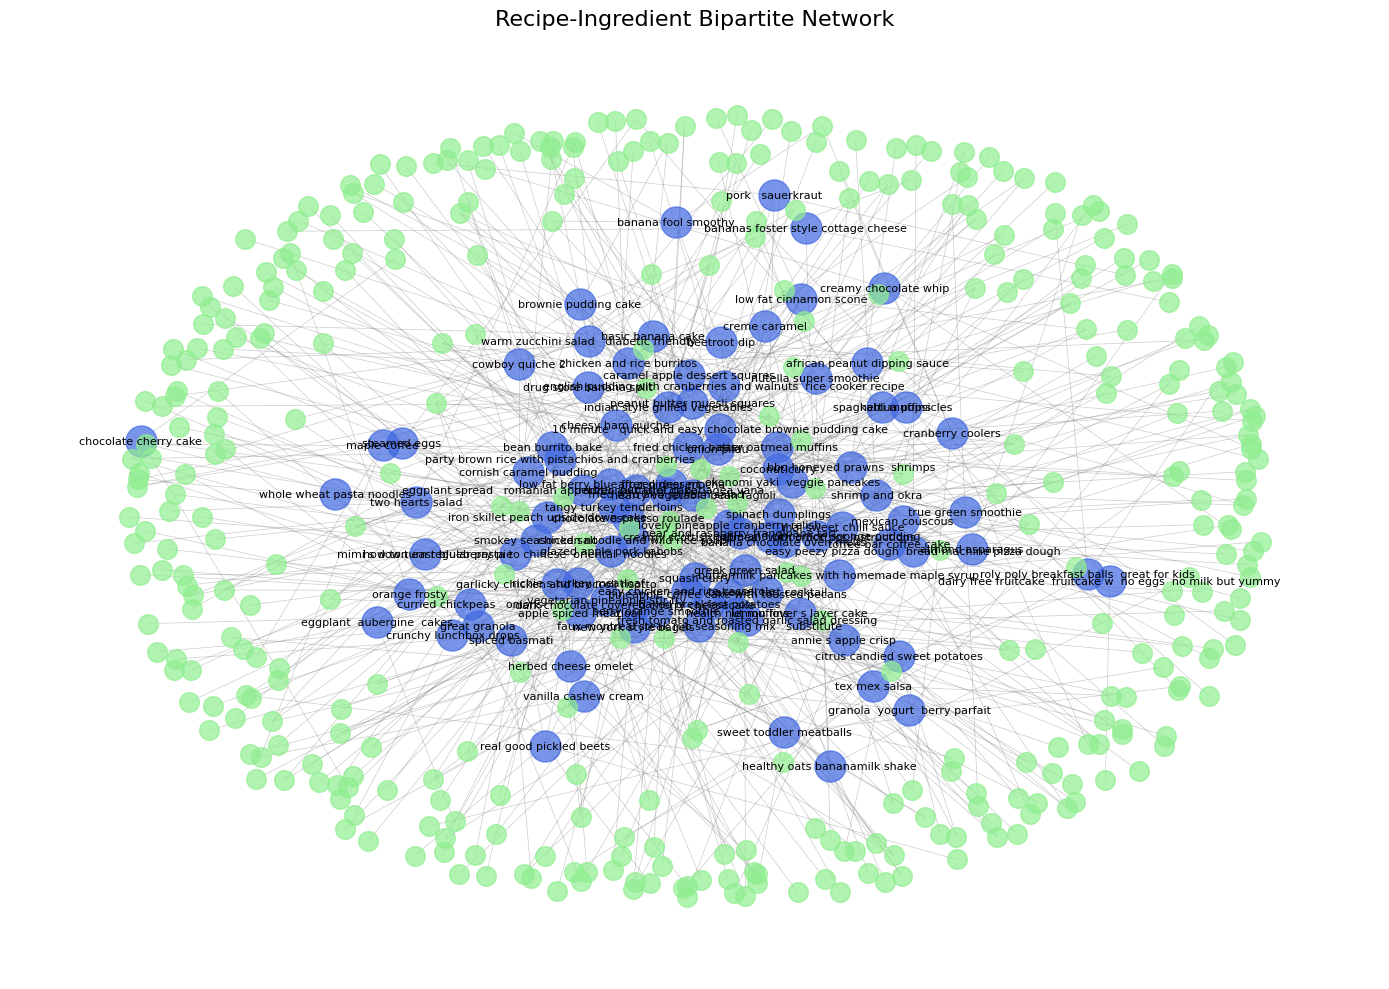

In [ ]:
### larger network:
recipe_name_map = dict(zip(df_subset['id'], df_subset['name']))
plt = visualize_large_bipartite_network(B, recipe_name_map)
# plt.savefig('bipartite_network.png', dpi=300)
plt.show()

## Main Functions

In [ ]:
# --- function to run all analyses ---
def analyze_bipartite_network(B, recipe_name_map=None):
    """ Run full analysis on the bipartite network B."""

    # 1. Create projections
    recipe_proj, ingredient_proj = create_projections(B)

    # 2. Basic network analysis
    proj_analysis = analyze_projections(recipe_proj, ingredient_proj)

    # 3. Matrix analysis
    matrix_results = matrix_analysis(B)

    # 4. Visualize projections
    visualize_projections(recipe_proj, ingredient_proj, recipe_name_map)

    # 5. Return combined results
    return {
        'projections': {
            'recipe_projection': recipe_proj,
            'ingredient_projection': ingredient_proj
        },
        'analysis': proj_analysis,
        'matrix_analysis': matrix_results
    }

-------------------------
Recipe Projection Analysis:
- nodes: 100
- edges: 1691
- density: 0.3416161616161616
- avg_weight: 1.518628030751035
- max_weight: 7
- connected_components: 3
- clustering_coef: 0.13648613483794184
-------------------------
Ingredient Projection Analysis:
- nodes: 396
- edges: 3065
- density: 0.0391893619741721
- avg_weight: 1.1814029363784666
- max_weight: 15
- connected_components: 3
- clustering_coef: 0.06218042245966806
-------------------------
Top ingredients by weighted degree:
- salt: 380
- butter: 186
- eggs: 156
- water: 143
- brown sugar: 141


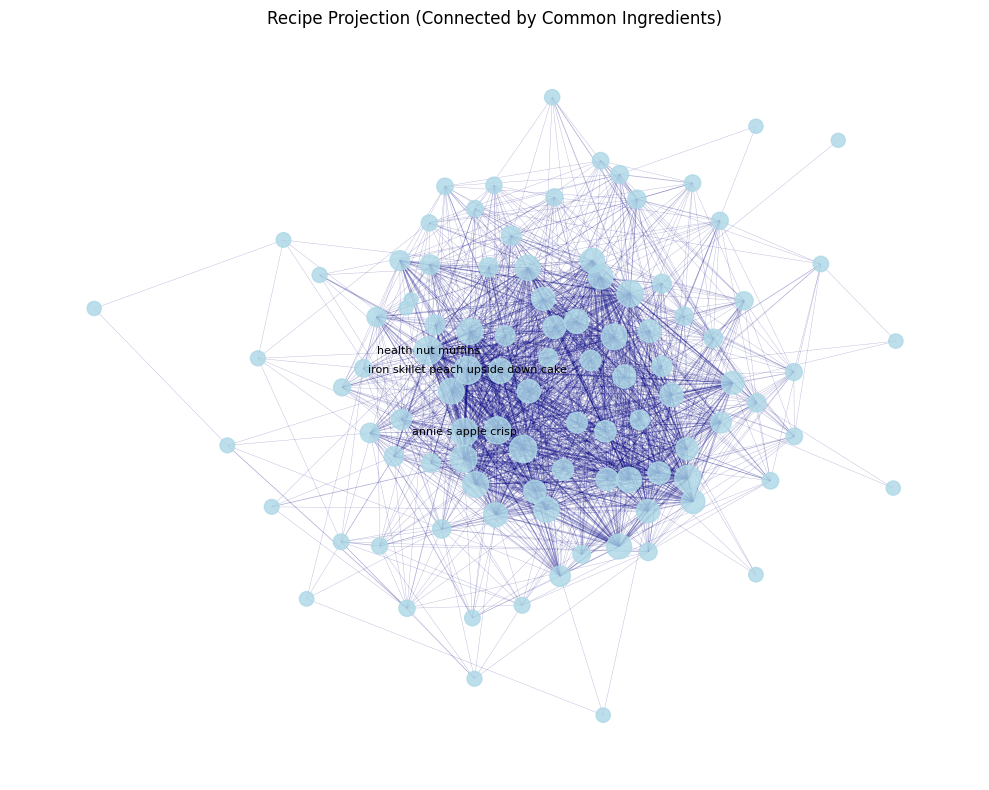

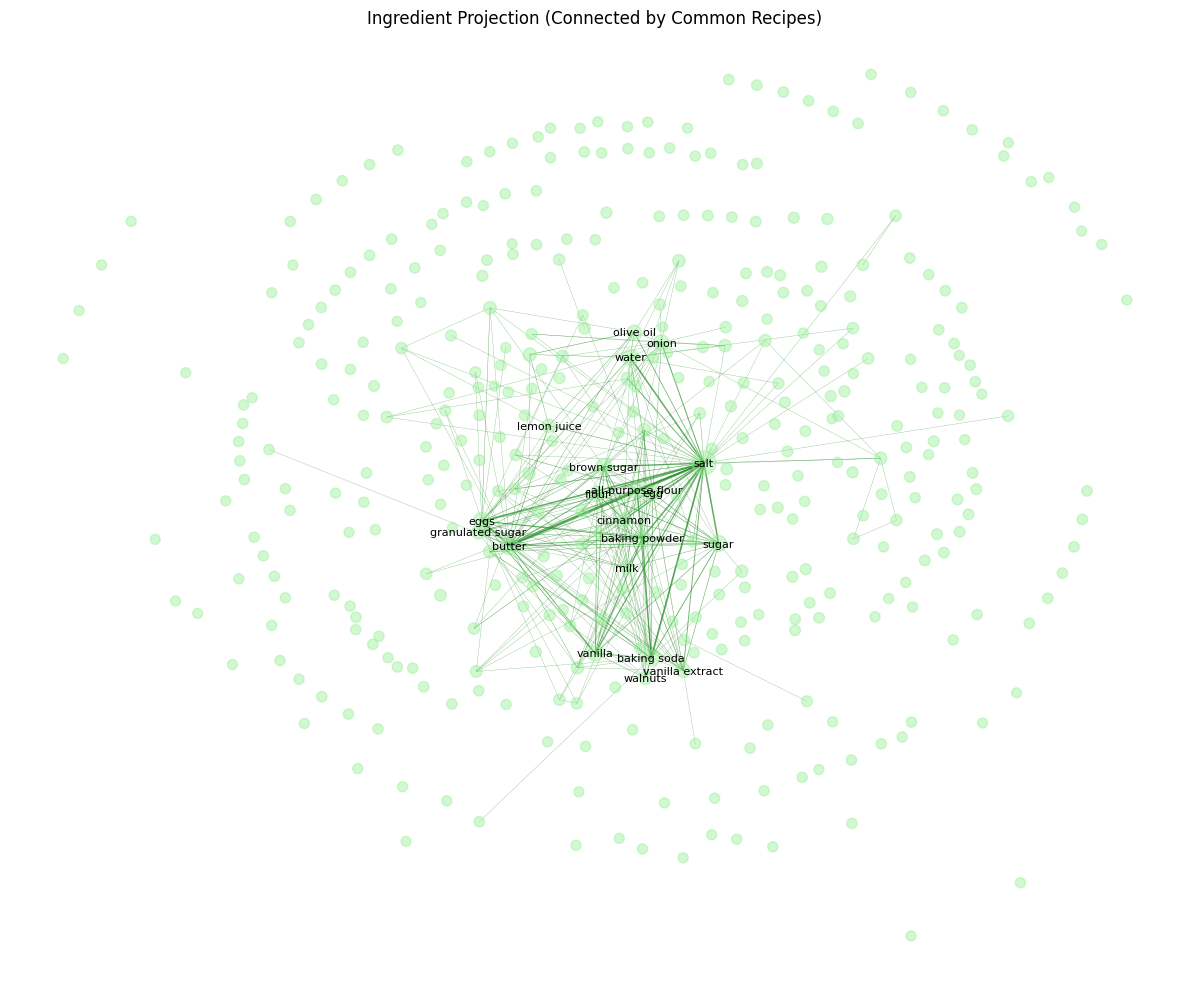

In [ ]:
recipe_name_map = dict(zip(df_subset['id'], df_subset['name']))
results = analyze_bipartite_network(B, recipe_name_map)

### key analysis results
print("-------------------------")
print("Recipe Projection Analysis:")
for key, value in results['analysis']['recipes'].items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

print("-------------------------")
print("Ingredient Projection Analysis:")
for key, value in results['analysis']['ingredients'].items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

### top ingredients by weighted degree
print("-------------------------")
top_ingredients = sorted(results['analysis']['ingredients']['weighted_degree'].items(),
                        key=lambda x: x[1], reverse=True)[:5]
print("Top ingredients by weighted degree:")
for ing, degree in top_ingredients:
    print(f"- {ing}: {degree}")

# Cuisine Analysis

## Getting Recipes for Top 10 Cuisines

In [ ]:
# Create cuisine list
cuisine_list = np.array(['north-american', 'mexican', 'american', 'northeastern-united-states',
                         'amish-mennonite', 'canadian', 'south-west-pacific', 'hawaiian',
                         'southwestern-united-states', 'asian', 'indian', 'californian', 'german',
                         'european', 'italian', 'midwestern', 'southern-united-states', 'indonesian',
                         'pacific-northwest', 'polish', 'chinese', 'british-columbian', 'danish',
                         'scandinavian', 'swiss', 'swedish', 'french', 'african', 'creole',
                         'cajun', 'australian', 'caribbean', 'central-american', 'english', 'quebec',
                         'middle-eastern', 'lebanese', 'greek', 'south-american', 'russian', 'baja',
                         'japanese', 'native-american', 'spanish', 'irish', 'polynesian', 'thai',
                         'ontario', 'tex-mex', 'south-african', 'new-zealand', 'pennsylvania-dutch',
                         'welsh', 'filipino', 'cuban', 'korean', 'belgian', 'finnish', 'moroccan',
                         'iranian', 'persian', 'dutch', 'turkish', 'portuguese', 'hungarian', 'brazilian',
                         'egyptian', 'vietnamese', 'norwegian', 'austrian', 'soul'])

cuisine_recipes = recipes[recipes['tags'].apply(lambda tags: any(tag in cuisine_list for tag in tags))]
cuisine_recipes['tags']

0         [60-minutes-or-less, time-to-make, course, mai...
1         [30-minutes-or-less, time-to-make, course, mai...
4         [weeknight, time-to-make, course, main-ingredi...
5         [15-minutes-or-less, time-to-make, course, mai...
6         [15-minutes-or-less, time-to-make, course, mai...
                                ...                        
231624    [15-minutes-or-less, time-to-make, course, mai...
231625    [60-minutes-or-less, time-to-make, course, mai...
231626    [weeknight, time-to-make, course, main-ingredi...
231629    [15-minutes-or-less, time-to-make, course, cui...
231631    [ham, 60-minutes-or-less, time-to-make, course...
Name: tags, Length: 91102, dtype: object

In [ ]:
len(cuisine_list)

71

In [ ]:
# Keep only recipes with top ten cuisines

tags = {tag:val for (tag, val) in tags_raw.items() if val > 150}
sorted_tags = dict(sorted(tags.items(), key=lambda item: item[1], reverse=True))
cuisine_tags = {tag: val for tag, val in sorted_tags.items() if tag in cuisine_list}
top_10_cuisines_list = list(cuisine_tags.items())[:10]
top_10_cuisines = [cuisine for cuisine, _ in top_10_cuisines_list]

print(top_10_cuisines)

cuisine_recipes_top = cuisine_recipes[cuisine_recipes['tags'].apply(lambda tags: any(tag in top_10_cuisines for tag in tags))]

['north-american', 'american', 'european', 'asian', 'italian', 'southern-united-states', 'mexican', 'canadian', 'south-west-pacific', 'southwestern-united-states']


In [ ]:
# Take a subset

n_recipes = 100
cuisine_sub = cuisine_recipes_top.sample(n=n_recipes, random_state=42)

top_cuisine_network = build_bipartite_graph(cuisine_sub)

Bipartite graph has 572 nodes and 890 edges


In [ ]:
# Difference in networks with top 10 vs all
build_bipartite_graph(cuisine_recipes)
build_bipartite_graph(cuisine_recipes_top)

Bipartite graph has 102962 nodes and 874738 edges
Bipartite graph has 98298 nodes and 828003 edges


In [ ]:
# Create projections

build_bipartite_graph(cuisine_recipes)

Bipartite graph has 102962 nodes and 874738 edges


In [ ]:
# Get projections
recipe_proj_top, ingredient_proj_top = create_projections(top_cuisine_network)

## Centrality Analysis

In [ ]:
# Centrality from ingredient projection

def get_central_ingredients(ingredient_projection, top_n=10):
    """Get the most central ingredients using degree centrality."""
    # Degree centrality
    degree = nx.degree_centrality(ingredient_projection)

    # Betweenness centrality
    betweenness = nx.betweenness_centrality(ingredient_projection, normalized=True)

    # Closeness centrality
    closeness = nx.closeness_centrality(ingredient_projection)

    # Eigenvector centrality (handle potential convergence issues)
    try:
        eigenvector = nx.eigenvector_centrality(ingredient_projection, max_iter=1000)
    except nx.NetworkXError:
        eigenvector = {node: 0 for node in ingredient_projection.nodes}

    # Sort and return the top N ingredients for each measure
    centrality_measures = {
        "Degree Centrality": sorted(degree.items(), key=lambda x: x[1], reverse=True)[:top_n],
        "Betweenness Centrality": sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n],
        "Closeness Centrality": sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:top_n],
        "Eigenvector Centrality": sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:top_n]
    }

    avg_centrality = {
        "Degree Centrality": sum(degree.values()) / len(degree),
        "Betweenness Centrality": sum(betweenness.values()) / len(betweenness),
        "Closeness Centrality": sum(closeness.values()) / len(closeness),
        "Eigenvector Centrality": sum(eigenvector.values()) / len(eigenvector)
    }

    return centrality_measures, avg_centrality

In [ ]:
# Centrality measures for top 10 cuisines
top_central_ingredients, avg_central_ingredients = get_central_ingredients(ingredient_proj_top, top_n=10)

# Print the most central ingredients nicely
for measure, ingredients in top_central_ingredients.items():
    print(f"\nTop 10 Ingredients by {measure}: ")
    for rank, (ingredient, score) in enumerate(ingredients, start=1):
        print(f"{rank}. {ingredient}: {score:.4f}")

print(avg_central_ingredients)


Top 10 Ingredients by Degree Centrality: 
1. salt: 0.4352
2. water: 0.2718
3. olive oil: 0.2718
4. butter: 0.2548
5. sugar: 0.2399
6. brown sugar: 0.2208
7. eggs: 0.1911
8. parmesan cheese: 0.1783
9. flour: 0.1783
10. garlic: 0.1741

Top 10 Ingredients by Betweenness Centrality: 
1. salt: 0.1745
2. water: 0.1230
3. butter: 0.1006
4. brown sugar: 0.0907
5. olive oil: 0.0799
6. sugar: 0.0705
7. parmesan cheese: 0.0573
8. garlic: 0.0417
9. onion: 0.0406
10. black pepper: 0.0366

Top 10 Ingredients by Closeness Centrality: 
1. salt: 0.6197
2. water: 0.5647
3. butter: 0.5594
4. brown sugar: 0.5548
5. olive oil: 0.5548
6. sugar: 0.5464
7. flour: 0.5328
8. eggs: 0.5280
9. onion: 0.5268
10. parmesan cheese: 0.5263

Top 10 Ingredients by Eigenvector Centrality: 
1. salt: 0.2945
2. olive oil: 0.2018
3. water: 0.1828
4. butter: 0.1807
5. sugar: 0.1763
6. flour: 0.1752
7. brown sugar: 0.1684
8. eggs: 0.1619
9. parmesan cheese: 0.1425
10. onions: 0.1398
{'Degree Centrality': 0.03452805066753043, '

In [ ]:
# Narrow cuisines

best_three = (['american', 'italian', 'mexican'])
print(best_three)

cuisine_recipes_top_three = cuisine_recipes[cuisine_recipes['tags'].apply(lambda tags: any(tag in best_three for tag in tags))]

['american', 'italian', 'mexican']


In [ ]:
# Ingredient projection of top three cuisines

n_recipes = 100
cuisine_sub_three = cuisine_recipes_top_three.sample(n=n_recipes, random_state=42)

top_three_cuisine_network = build_bipartite_graph(cuisine_sub_three)

recipe_proj_top_three, ingredient_proj_top_three = create_projections(top_three_cuisine_network)

recipe_proj_top_three_2, ingredient_proj_top_three_2 = create_projections(top_three_cuisine_network)

Bipartite graph has 550 nodes and 896 edges


In [ ]:
# Removing most popular ingredients

ingredient_proj_top_three.remove_node('water')
ingredient_proj_top_three.remove_node('salt')
ingredient_proj_top_three.remove_node('butter')
ingredient_proj_top_three.remove_node('olive oil')
ingredient_proj_top_three.remove_node('pepper')
ingredient_proj_top_three.remove_node('black pepper')
ingredient_proj_top_three.remove_node('sugar')

In [ ]:
# American, mexican, and italian top ingredients by type of centrality

top_three_central_ingredients, top_three_avg_ingredients = get_central_ingredients(ingredient_proj_top_three, top_n=10)

# Print the most central ingredients nicely
for measure, ingredients in top_three_central_ingredients.items():
    print(f"\nTop 10 Ingredients by {measure}: ")
    for rank, (ingredient, score) in enumerate(ingredients, start=1):
        print(f"{rank}. {ingredient}: {score:.4f}")


Top 10 Ingredients by Degree Centrality: 
1. onion: 0.3982
2. garlic cloves: 0.2217
3. brown sugar: 0.1833
4. eggs: 0.1742
5. flour: 0.1697
6. milk: 0.1674
7. parmesan cheese: 0.1629
8. garlic: 0.1538
9. ground cumin: 0.1448
10. celery: 0.1380

Top 10 Ingredients by Betweenness Centrality: 
1. onion: 0.2409
2. garlic cloves: 0.0870
3. eggs: 0.0757
4. brown sugar: 0.0666
5. flour: 0.0482
6. milk: 0.0440
7. parmesan cheese: 0.0369
8. garlic: 0.0365
9. potatoes: 0.0365
10. ground cumin: 0.0299

Top 10 Ingredients by Closeness Centrality: 
1. onion: 0.5907
2. garlic cloves: 0.5109
3. eggs: 0.4936
4. milk: 0.4918
5. flour: 0.4918
6. brown sugar: 0.4833
7. celery: 0.4740
8. worcestershire sauce: 0.4723
9. parmesan cheese: 0.4695
10. salt and pepper: 0.4661

Top 10 Ingredients by Eigenvector Centrality: 
1. onion: 0.3431
2. garlic cloves: 0.2022
3. parmesan cheese: 0.1807
4. ground cumin: 0.1559
5. flour: 0.1557
6. milk: 0.1529
7. celery: 0.1525
8. garlic: 0.1487
9. worcestershire sauce: 0.1

## Clustering Analysis

In [ ]:
# Clustering coeff for top 30 ingredients
degrees = dict(ingredient_proj_top_three_2.degree())

top_ingred = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:30]
top_ingred_nodes = [ingredient for ingredient, _ in top_ingred]
subgraph = ingredient_proj_top_three_2.subgraph(top_ingred_nodes)
clustering_coeffs = nx.clustering(subgraph)
avg_clustering = sum(clustering_coeffs.values()) / len(clustering_coeffs)
print("Clustering Coefficients for Top 30 Ingredients: ")
for ingredient, coeff in clustering_coeffs.items():
    print(f"{ingredient}: {coeff:.4f}")

# Average cliquishness for top 30 ingredients
print(f"Average Cliquishness for Top 30 Ingredients (Clustering Coefficient): {avg_clustering:.4f}")

Clustering Coefficients for Top 30 Ingredients: 
worcestershire sauce: 0.6257
sugar: 0.8000
garlic: 0.8286
salt: 0.5320
salt and pepper: 0.7143
eggs: 0.7083
potatoes: 0.7253
butter: 0.6684
bay leaves: 0.9011
vegetable oil: 0.9722
brown sugar: 0.7363
onion: 0.5450
ground cumin: 0.7721
dried oregano: 0.9121
milk: 0.7417
bacon: 0.7636
celery: 0.7132
garlic cloves: 0.5652
tomatoes: 0.7368
fresh basil: 0.8222
fresh ground black pepper: 0.8222
black pepper: 0.8182
flour: 0.7353
parmesan cheese: 0.6619
olive oil: 0.5906
extra virgin olive oil: 0.7636
cayenne pepper: 0.8132
water: 0.5499
honey: 0.7857
pepper: 0.8022
Average Cliquishness for Top 30 Ingredients (Clustering Coefficient): 0.7376


In [ ]:
# Connected components and giant component

print(nx.number_connected_components(ingredient_proj_top_three_2))
giant = sorted(nx.connected_components(ingredient_proj_top_three_2), key=len, reverse=True)[0]
print(len(giant))

7
432


In [ ]:
# Clustering coeff for bottom thirty ingredients
bot_ingred = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[-30:]
bot_ingred_nodes = [ingredient for ingredient, _ in bot_ingred]
subgraph1 = ingredient_proj_top_three_2.subgraph(bot_ingred_nodes)
clustering_coeffs1 = nx.clustering(subgraph1)
avg_clustering1 = sum(clustering_coeffs1.values()) / len(clustering_coeffs1)
print("Clustering Coefficients for Bottom 30 Ingredients: ")
for ingredient, coeff in clustering_coeffs1.items():
    print(f"{ingredient}: {coeff:.4f}")

# Maybe just talk about this number
print(f"Average Cliquishness For Less Popular Ingredients: {avg_clustering1:.4f}")

Clustering Coefficients for Bottom 30 Ingredients: 
vanilla yogurt: 0.0000
refried beans: 0.0000
italian breadcrumbs: 1.0000
orange bell peppers: 1.0000
cabbage: 0.0000
amaretto: 0.0000
red bell peppers: 1.0000
raspberry jam: 0.0000
ice cubes: 1.0000
clementine: 0.0000
peach soda: 0.0000
bacon grease: 0.0000
jiffy corn muffin mix: 0.0000
vanilla liqueur: 1.0000
pepsi: 1.0000
dried onion flakes: 0.0000
vanilla schnapps: 1.0000
italian salad dressing: 1.0000
chicken parts: 1.0000
beer: 0.0000
eggnog: 0.0000
sodium-free beef bouillon granules: 0.0000
orange soda: 1.0000
creamed corn: 0.0000
peaches: 0.0000
yellow bell peppers: 1.0000
sweet pickles: 0.0000
caster sugar: 0.0000
semi-sweet chocolate chips: 0.0000
ice: 1.0000
Average Cliquishness For Less Popular Ingredients: 0.4000


## Visualizations

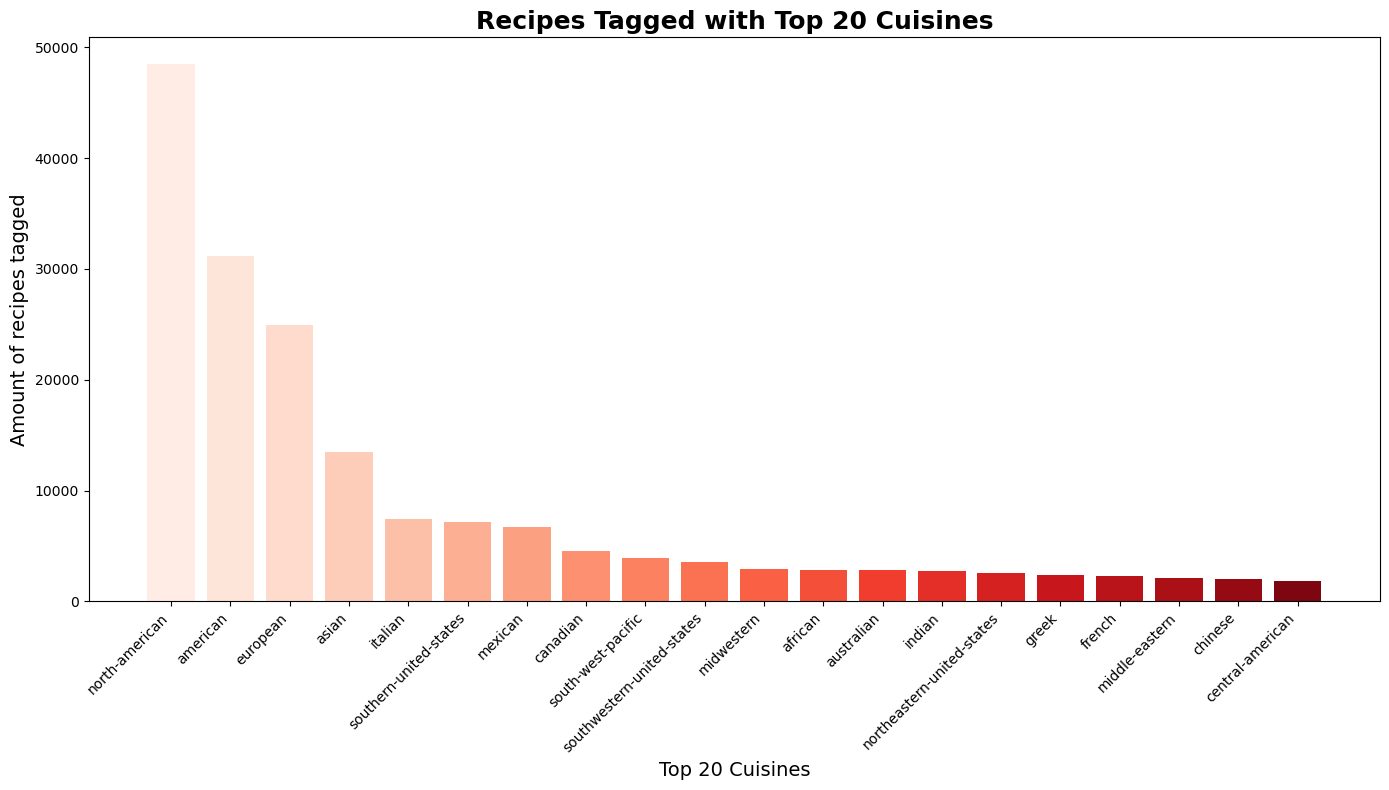

In [ ]:
# Graph for amount of recipes of certain cuisines
top_20 = {k: v for i, (k, v) in enumerate(cuisine_tags.items()) if i < 20}

plt.figure(figsize=(14, 8))
colors = sns.color_palette("Reds", len(top_20))
bars = plt.bar(range(len(top_20)), list(top_20.values()), align='center', color = colors)
plt.xticks(range(len(top_20)), list(top_20.keys()), rotation = 45, ha = 'right')
plt.title("Recipes Tagged with Top 20 Cuisines", fontsize = 18, weight = "bold")
plt.xlabel("Top 20 Cuisines", fontsize = 14)
plt.ylabel("Amount of recipes tagged", fontsize = 14)
plt.tight_layout()
plt.show()

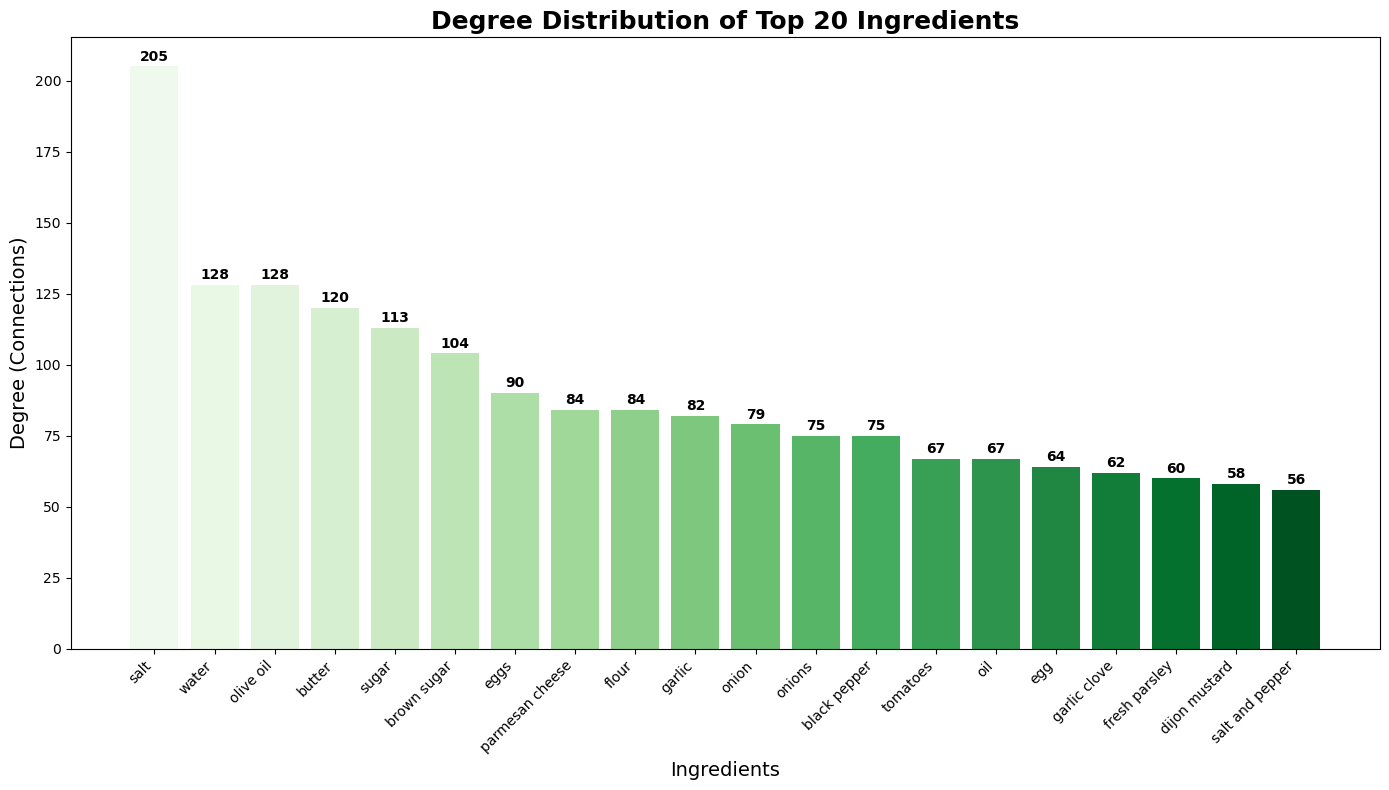

In [ ]:
# Graph for degree distribution of top 20 ingredients

degrees = dict(ingredient_proj_top.degree())

top_ingredients = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]

ingredients, degree_values = zip(*top_ingredients)

plt.figure(figsize=(14, 8))

colors = sns.color_palette("Greens", len(ingredients))
bars = plt.bar(ingredients, degree_values, color=colors)


plt.title(f"Degree Distribution of Top 20 Ingredients", fontsize=18, weight='bold')
plt.xlabel("Ingredients", fontsize=14)
plt.ylabel("Degree (Connections)", fontsize=14)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Top 50 Recipes Analysis

In [ ]:
# Take a random subset of 5000 recipes for later centrality comparison to a subset representative of the full dataset
n_recipes = 5000
df_subset = recipes.sample(n=n_recipes, random_state=42)

# Build bipartite network for the 5000-recipe subset
B_5000 = build_bipartite_graph(df_subset)
recipe_proj_full, ingredient_proj_full = create_projections(B_5000)

# Take the subset of the top 50 most frequently rated/reviewed recipes
top_recipe_ids = interactions.groupby('recipe_id').size().sort_values(ascending=False).head(50).index.tolist()
top50recipes = recipes[recipes['id'].isin(top_recipe_ids)]

# Build bipartite network for the top 50 recipes
B_top50 = build_bipartite_graph(top50recipes)
recipe_proj, ingredient_proj = create_projections(B_top50)

Bipartite graph has 9222 nodes and 44825 edges
Bipartite graph has 283 nodes and 494 edges


-------------------------
Recipe Projection Analysis:
- nodes: 50
- edges: 690
- density: 0.563265306122449
- avg_weight: 1.8014492753623188
- max_weight: 7
- connected_components: 1
- clustering_coef: 0.18417934100433755
-------------------------
Ingredient Projection Analysis:
- nodes: 233
- edges: 2038
- density: 0.07540328548172266
- avg_weight: 1.225711481844946
- max_weight: 15
- connected_components: 1
- clustering_coef: 0.06468062789381163
-------------------------
Top ingredients by weighted degree:
- salt: 270
- butter: 204
- onion: 123
- sugar: 114
- eggs: 114


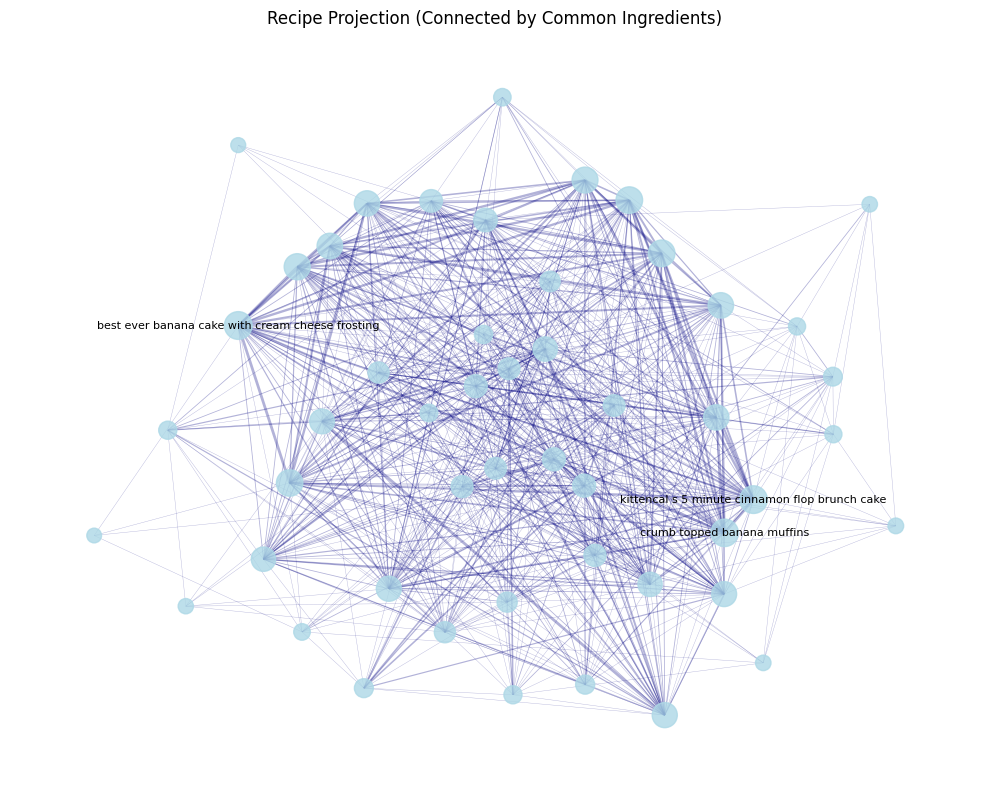

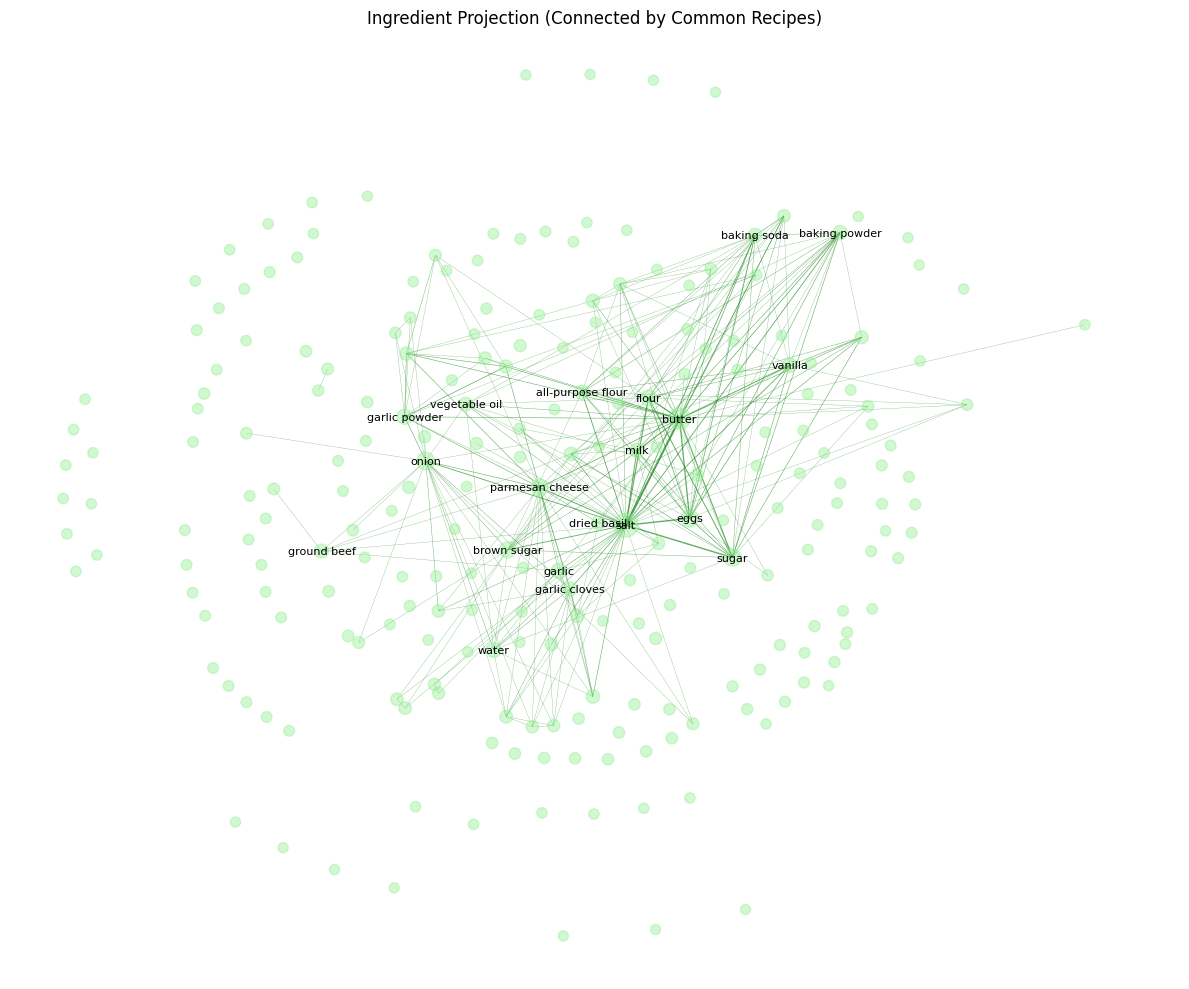

In [ ]:
recipe_name_map = dict(zip(top50recipes['id'], top50recipes['name']))
results = analyze_bipartite_network(B_top50, recipe_name_map)

### key analysis results
print("-------------------------")
print("Recipe Projection Analysis:")
for key, value in results['analysis']['recipes'].items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

print("-------------------------")
print("Ingredient Projection Analysis:")
for key, value in results['analysis']['ingredients'].items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

### top ingredients by weighted degree
print("-------------------------")
top_ingredients = sorted(results['analysis']['ingredients']['weighted_degree'].items(),
                        key=lambda x: x[1], reverse=True)[:5]
print("Top ingredients by weighted degree:")
for ing, degree in top_ingredients:
    print(f"- {ing}: {degree}")

In [ ]:
# Calculate centralities for the top 50 recipes
degree_centrality = nx.degree_centrality(ingredient_proj) # Automatically normalized
betweenness_centrality = nx.betweenness_centrality(ingredient_proj, weight='weight')
closeness_centrality = nx.closeness_centrality(ingredient_proj, distance='weight')

sorted_degree = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
sorted_betweenness = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
sorted_closeness = dict(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))

# Calculate centralities for the 5000-recipe subset
degree_centrality_full = nx.degree_centrality(ingredient_proj_full) # Automatically normalized
betweenness_centrality_full = nx.betweenness_centrality(ingredient_proj_full, weight='weight')
closeness_centrality_full = nx.closeness_centrality(ingredient_proj_full, distance='weight')

# Calculate differences between centrality values for each network,
# sort them in descending order, and print them
degree_diff = {}
betweenness_diff = {}
closeness_diff = {}
for ingredient, centrality in sorted_degree.items():
    if ingredient in degree_centrality_full:
        degree_diff[ingredient] = centrality - degree_centrality_full[ingredient]
    else:
        degree_diff[ingredient] = 0
for ingredient, centrality in sorted_betweenness.items():
    if ingredient in betweenness_centrality_full:
        betweenness_diff[ingredient] = centrality - betweenness_centrality_full[ingredient]
    else:
        betweenness_diff[ingredient] = 0
for ingredient, centrality in sorted_closeness.items():
    if ingredient in closeness_centrality_full:
        closeness_diff[ingredient] = centrality - closeness_centrality_full[ingredient]
    else:
        closeness_diff[ingredient] = 0

sorted_d_diffs = dict(sorted(degree_diff.items(), key=lambda item: item[1], reverse=True))
sorted_b_diffs = dict(sorted(betweenness_diff.items(), key=lambda item: item[1], reverse=True))
sorted_c_diffs = dict(sorted(closeness_diff.items(), key=lambda item: item[1], reverse=True))

print("\nDegree Centrality Differences:")
for ingredient, diff in sorted_d_diffs.items():
    print(f"- {ingredient}: {diff}")

print("\nBetweenness Centrality Differences:")
for ingredient, diff in sorted_b_diffs.items():
    print(f"- {ingredient}: {diff}")

print("\nCloseness Centrality Differences:")
for ingredient, diff in sorted_c_diffs.items():
    print(f"- {ingredient}: {diff}")


Degree Centrality Differences:
- ground beef: 0.11933150340252757
- fresh coarse ground black pepper: 0.10296730632551528
- dried basil: 0.1006227074806591
- dried parsley flakes: 0.09472853303270183
- parmesan cheese: 0.08585969985867051
- cocoa: 0.08491614178696011
- italian sausage: 0.08454137359181105
- lean ground beef: 0.08140128585316438
- chili peppers: 0.08071199830077853
- brown sugar: 0.07751472522445241
- dark beer: 0.07549996323799721
- salt: 0.07110996740435749
- strong coffee: 0.07076174954455963
- flour tortillas: 0.06530565562989649
- seasoning salt: 0.06529850746268656
- garlic powder: 0.06237388590708198
- icing sugar: 0.06232486990335678
- lasagna noodles: 0.05830453643114477
- beef broth: 0.05648685962633465
- thin spaghetti: 0.05588947708093359
- dried oregano: 0.055761831237899157
- chili sauce: 0.05488873367154375
- m&m': 0.0548499293352613
- vanilla: 0.05429441462637549
- barbecue sauce: 0.05284844251648163
- white sugar: 0.05265033616809221
- english cucumber

# Temporal Analysis

#### Functions

In [ ]:
# Temporal analysis

def food_over_time_bar_multi(df: pd.DataFrame, food1: str, food2: str, food3: str, colors: list = ["lightgreen", "steelblue", "seagreen"]):
    recipes_df = df.copy()

    # Compute prevalence for all three foods
    recipes_df["food1_present"] = recipes_df.ingredients.apply(lambda x: food1.lower() in x)
    recipes_df["food2_present"] = recipes_df.ingredients.apply(lambda x: food2.lower() in x)
    recipes_df["food3_present"] = recipes_df.ingredients.apply(lambda x: food3.lower() in x)

    m_grouped1 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food1_present"].mean().reset_index()
    m_grouped2 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food2_present"].mean().reset_index()
    m_grouped3 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food3_present"].mean().reset_index()

    # Ensure submitted column is datetime type
    m_grouped1["submitted"] = pd.to_datetime(m_grouped1["submitted"])
    m_grouped2["submitted"] = pd.to_datetime(m_grouped2["submitted"])
    m_grouped3["submitted"] = pd.to_datetime(m_grouped3["submitted"])

    # Convert to percentage
    m_grouped1["food1_present"] *= 100
    m_grouped2["food2_present"] *= 100
    m_grouped3["food3_present"] *= 100

    # Set default colors if none are provided
    default_colors = ['steelblue', 'indianred', 'seagreen']
    if colors is None or len(colors) < 3:
        colors = (colors or []) + default_colors[len(colors or []):]

    f, ax = plt.subplots(1, 1, figsize=(10, 6))

    bar_width = 160  # Controls bar width

    # Plot all three foods with specified colors
    ax.bar(m_grouped1["submitted"], m_grouped1["food1_present"], color=colors[0], width=bar_width, label=food1, alpha=0.7)
    ax.bar(m_grouped2["submitted"], m_grouped2["food2_present"], color=colors[1], width=bar_width, label=food2, alpha=0.7)
    ax.bar(m_grouped3["submitted"], m_grouped3["food3_present"], color=colors[2], width=bar_width, label=food3, alpha=0.7)

    # Properly format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=16))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))

    ax.set_xlabel('Date')
    ax.set_ylabel(r'% of Recipes Uploaded using this Food')
    ax.legend()

    plt.show()

def sample_with_foods(df: pd.DataFrame, foods: list, n: int = 5000, random_state: int = 42):
    """
    Samples 'n' rows from the given DataFrame, ensuring at least one observation contains
    one of the specified foods in the 'ingredients' column.

    Args:
    - df (pd.DataFrame): The DataFrame to sample from.
    - foods (list): A list of food items to ensure at least one is included in the sample.
    - n (int): The number of rows to sample (default is 5000).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: A sample of the DataFrame with at least one specified food included.
    """

    # Filter rows that contain any of the specified foods
    food_rows = df[df['ingredients'].apply(lambda x: any(food.lower() in [ingredient.lower() for ingredient in x] for food in foods))]

    # If there are food_rows available, ensure one is in the sample
    if not food_rows.empty:
        # Sample (n-1) rows from the rest of the DataFrame and add one food row
        sample_with_food = pd.concat([food_rows.sample(n=1, random_state=random_state),
                                      df.drop(food_rows.index).sample(n=n-1, random_state=random_state)])
        return sample_with_food
    else:
        # If no rows with the specified foods, sample normally
        return df.sample(n=n, random_state=random_state)

def ingredient_create_projections(B, weighted=True):
    """Create the 2  projections (onto recipes & ingredients) of bipartite graph B."""
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    if weighted:
        # based on number of common connections
        ingredient_projection = nx.bipartite.weighted_projected_graph(B, ingredients)

    else:
        ingredient_projection = nx.bipartite.projected_graph(B, ingredients)

    return ingredient_projection

def calculate_centralities_limited(B, betweenness_nodes=None, betweenness_k=1000):
    # Degree Centrality
    degree_centrality = nx.degree_centrality(B)

    # If no specific nodes are given for betweenness centrality, calculate for top 'k' nodes based on degree
    if betweenness_nodes is None:
        nodes_to_calculate_betweenness = sorted(B.nodes(), key=lambda x: B.degree(x), reverse=True)[:betweenness_k]
    else:
        # Use the specified subset of nodes
        nodes_to_calculate_betweenness = betweenness_nodes

    # Betweenness Centrality (limit to the specified nodes)
    betweenness_centrality = nx.betweenness_centrality(B, normalized=True)
    # Only keep betweenness centrality for the selected subset of nodes
    betweenness_centrality = {node: betweenness_centrality[node] for node in nodes_to_calculate_betweenness}

    # Closeness Centrality
    closeness_centrality = nx.closeness_centrality(B)

    # Eigenvector Centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(B, max_iter=1000, tol=1e-06)
    except nx.NetworkXException as e:
        print("Eigenvector centrality did not converge:", e)
        eigenvector_centrality = None

    # Return centrality measures as a dictionary
    centralities = {
        'degree_centrality': degree_centrality,
        'betweenness_centrality': betweenness_centrality,
        'closeness_centrality': closeness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
    }

    return centralities

def centrality_dataframe(centrality_dict, foods):
    """
    Create a DataFrame with foods as rows and centralities as columns.

    Args:
        centrality_dict (dict): A dictionary where keys are centrality types and values are dictionaries mapping nodes to scores.
        foods (list): List of foods to analyze.

    Returns:
        pd.DataFrame: A DataFrame with foods as rows and centralities as columns.
    """
    data = {food: {} for food in foods}  # Initialize dictionary with food as keys

    for centrality, values in centrality_dict.items():
        for food in foods:
            data[food][centrality] = values.get(food, None)  # Assign value or None if missing

    return pd.DataFrame.from_dict(data, orient='index')

def measure_clustering_for_nodes(G, nodes_of_interest, use_weight=True):
    """
    Calculate the local clustering coefficient for specified nodes and return a DataFrame.

    Parameters:
    - G (networkx.Graph): The one-mode projection graph.
    - nodes_of_interest (list): List of node names (e.g., ['avocado', 'kale']).
    - use_weight (bool): Whether to consider edge weights.

    Returns:
    pd.DataFrame: A DataFrame with nodes as rows and their clustering coefficient.
    """
    clustering_data = {
        "Node": [],
        "Clustering_Coefficient": []
    }

    for node in nodes_of_interest:
        if node in G:
            coeff = nx.clustering(G, node, weight='weight') if use_weight else nx.clustering(G, node)
            clustering_data["Node"].append(node)
            clustering_data["Clustering_Coefficient"].append(coeff)
        else:
            clustering_data["Node"].append(node)
            clustering_data["Clustering_Coefficient"].append(None)  # Assign NaN if node is missing

    return pd.DataFrame(clustering_data).set_index("Node")

def get_top_neighbors(graph, ingredient, top_n=10):
    """
    Get the top N neighbors of a given ingredient based on edge weight.

    Args:
        graph (nx.Graph): The one-mode projection graph.
        ingredient (str): The ingredient whose neighbors we want to analyze.
        top_n (int): Number of top neighbors to return based on connection strength.

    Returns:
        dict: A dictionary where keys are neighbor nodes and values are connection strengths (edge weights).
    """
    ingredient = ingredient.lower()
    if ingredient not in graph:
        print(f"Ingredient '{ingredient}' not found in the graph.")
        return {}

    # Get neighbors and their edge weights
    neighbors_weights = {neighbor: graph[ingredient][neighbor]["weight"] for neighbor in graph.neighbors(ingredient)}

    # Sort by weight in descending order and return the top N
    top_neighbors = dict(sorted(neighbors_weights.items(), key=lambda x: x[1], reverse=True)[:top_n])

    return top_neighbors




#### Implementation

In [ ]:
recipes = pd.read_csv("RAW_recipes.csv")

n_recipes = len(recipes)
tags = recipes['tags'].copy()

for i in range(0, n_recipes):
  tags[i] = eval(recipes['tags'][i])

recipes['tags'] = tags

ingredients = recipes.ingredients.copy()
for i in range(0, n_recipes):
  ingredients[i] = eval(recipes.ingredients[i])

recipes.ingredients = ingredients

recipes.submitted = pd.to_datetime(recipes.submitted)

In [ ]:
# Subset DataFrame to include only recipes that have "dietary" in their tags
dietary_recipes = recipes[recipes['tags'].apply(lambda tags: isinstance(tags, list) and 'dietary' in tags)] # contains full data up to 2019


cutoff_date = pd.Timestamp("2007-06-30")
# Filter the DataFrame
dietary_recipes_subset = dietary_recipes[dietary_recipes['submitted'] <= cutoff_date] # only contains up to 2007
analyze_foods = ["avocado", "kale", "almond milk", "greek yogurt", "stevia"]

In [ ]:
diet = sample_with_foods(dietary_recipes, analyze_foods)
diet_subset = sample_with_foods(dietary_recipes_subset, analyze_foods)

In [ ]:
def check_food_in_ingredients(df: pd.DataFrame, food: str):
    """
    Checks if a specific food exists in the 'ingredients' column of the DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame to search.
    - food (str): The food item to search for in the 'ingredients' column.

    Returns:
    - bool: True if the food is found in the ingredients of any row, False otherwise.
    """

    # Filter rows where the ingredients contain the food
    food_rows = df[df['ingredients'].apply(lambda x: food.lower() in [ingredient.lower() for ingredient in x])]

    # If food_rows is not empty, print the rows containing the food and return True
    if not food_rows.empty:
        print(f"Rows containing '{food}':")
        # print(food_rows)
        return True
    else:
        print(f"No rows contain '{food}'.")
        return False

In [ ]:
import pandas as pd

def sample_with_foods(df: pd.DataFrame, foods: list, n: int = 5000,
                     max_attempts: int = 1000, random_state: int = 42) -> pd.DataFrame:
    """
    Samples 'n' rows repeatedly until all specified foods are found in the sample,
    or until maximum attempts are reached.

    Args:
        df (pd.DataFrame): DataFrame to sample from
        foods (list): List of foods that must all be present in the sample
        n (int): Sample size (default: 5000)
        max_attempts (int): Maximum sampling attempts (default: 100)
        random_state (int): Initial random seed (default: 42)

    Returns:
        pd.DataFrame: Sample containing all foods or best possible sample
    """
    # First validate food existence in original DataFrame
    missing_in_source = [food for food in foods
                        if not check_food_in_ingredients(df, food)]
    if missing_in_source:
        print(f"Warning: These foods don't exist in source data: {missing_in_source}")

    valid_foods = [food for food in foods if food not in missing_in_source]
    if not valid_foods:
        print("No valid foods to check - returning random sample")
        return df.sample(n=min(n, len(df)), random_state=random_state).reset_index(drop=True)

    # Sampling attempts loop
    for attempt in range(max_attempts):
        current_seed = random_state + attempt
        sample = df.sample(n=min(n, len(df)),
                          random_state=current_seed).reset_index(drop=True)

        # Check if all foods are present
        missing_in_sample = []
        for food in valid_foods:
            if not check_food_in_ingredients(sample, food):
                missing_in_sample.append(food)

        if not missing_in_sample:
            print(f"Success after {attempt+1} attempts!")
            return sample

    print(f"Failed after {max_attempts} attempts. Returning best sample")
    return sample

In [ ]:
diet = sample_with_foods(dietary_recipes, analyze_foods)
diet_subset = sample_with_foods(dietary_recipes_subset, analyze_foods)

Success after 1 attempts!
Success after 2 attempts!


In [ ]:
check_food_in_ingredients(diet_subset, "almond milk")

Rows containing 'almond milk':


True

In [ ]:
B_diet = build_bipartite_graph(diet)
B_diet_subset = build_bipartite_graph(diet_subset)

Bipartite graph has 8955 nodes and 44109 edges
Bipartite graph has 8999 nodes and 44031 edges


In [ ]:
subset_ingredient_proj = ingredient_create_projections(B_diet_subset)

In [ ]:
diet_ingredient_proj = ingredient_create_projections(B_diet)

In [ ]:
subset_centralities = calculate_centralities_limited(subset_ingredient_proj, analyze_foods)

In [ ]:
Diet_centralities = calculate_centralities_limited(diet_ingredient_proj, analyze_foods)

In [ ]:
subset_cent_df = centrality_dataframe(subset_centralities, analyze_foods)
Diet_cent_df = centrality_dataframe(Diet_centralities, analyze_foods)

In [ ]:
subset_coeffs = measure_clustering_for_nodes(subset_ingredient_proj, analyze_foods)
diet_coeffs = measure_clustering_for_nodes(diet_ingredient_proj, analyze_foods)

In [ ]:
measures_2007 = pd.merge(subset_cent_df, subset_coeffs, left_index=True, right_index=True, how='inner')
measures_2007

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,Clustering_Coefficient
avocado,0.048274,0.000549,0.500001,0.033550,0.001464
kale,0.015258,0.000056,0.473816,0.013116,0.002189
almond milk,0.002251,0.000000,0.398801,0.002271,0.003736
greek yogurt,0.004002,0.000000,0.449629,0.004984,0.004080
stevia,0.002751,0.000000,0.439428,0.003534,0.005985


In [ ]:
measures_full = pd.merge(Diet_cent_df, diet_coeffs, left_index=True, right_index=True, how='inner')
measures_full

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,Clustering_Coefficient
avocado,0.042742,0.000946,0.496289,0.029069,0.001462
kale,0.018968,0.000055,0.477656,0.016683,0.002039
almond milk,0.004299,0.000010,0.449664,0.003029,0.001925
greek yogurt,0.006323,0.000014,0.450486,0.006307,0.002549
stevia,0.006576,0.000015,0.456165,0.005338,0.002893


In [ ]:
measures_full - measures_2007

,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,Clustering_Coefficient
avocado,-0.005533,3.971456e-04,-0.003712,-0.004481,-0.000002
kale,0.003711,-8.851431e-07,0.003840,0.003567,-0.000151
almond milk,0.002048,1.013231e-05,0.050863,0.000758,-0.001811
greek yogurt,0.002321,1.369600e-05,0.000858,0.001323,-0.001532
stevia,0.003824,1.510462e-05,0.016738,0.001804,-0.003092


In [ ]:
get_top_neighbors(subset_ingredient_proj, "avocado")

{'salt': 13,
 'tomatoes': 11,
 'onion': 9,
 'garlic cloves': 8,
 'fresh cilantro': 7,
 'ground cumin': 7,
 'cilantro': 6,
 'red onion': 5,
 'garlic': 5,
 'fresh ground black pepper': 4}

In [ ]:
get_top_neighbors(diet_ingredient_proj, "avocado")

{'salt': 9,
 'red onion': 6,
 'salsa': 6,
 'tomatoes': 6,
 'cilantro': 6,
 'onion': 5,
 'jalapeno': 5,
 'sour cream': 4,
 'garlic': 4,
 'mayonnaise': 4}

In [ ]:
get_top_neighbors(subset_ingredient_proj, "kale")

{'olive oil': 5,
 'salt': 4,
 'garlic': 4,
 'onion': 3,
 'parmesan cheese': 3,
 'potatoes': 2,
 'extra virgin olive oil': 2,
 'garlic cloves': 2,
 'fresh thyme leaves': 1,
 'potato': 1}

In [ ]:
get_top_neighbors(diet_ingredient_proj, "kale")

{'onion': 3,
 'salt': 3,
 'garlic cloves': 3,
 'celery': 2,
 'potatoes': 2,
 'vegetable broth': 2,
 'water': 2,
 'cannellini beans': 2,
 'extra virgin olive oil': 2,
 'olive oil': 2}

<ipython-input-10-38c36507b970>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_grouped1 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food1_present"].mean().reset_index()
<ipython-input-10-38c36507b970>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_grouped2 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food2_present"].mean().reset_index()
<ipython-input-10-38c36507b970>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_grouped3 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food3_present"].mean().reset_index()


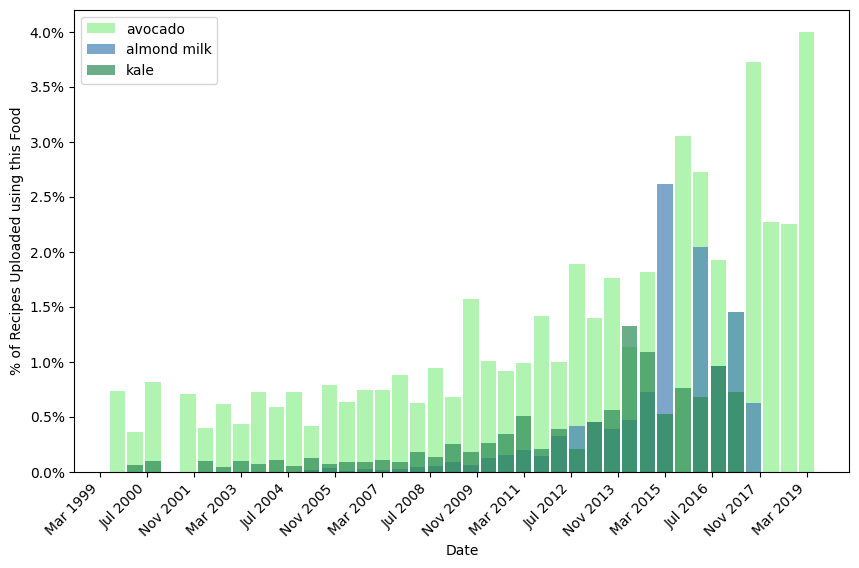

In [ ]:
food_over_time_bar_multi(recipes, "avocado", "almond milk", "kale", ["lightgreen", "steelblue", "seagreen"])